In [44]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

## Reading the data

In [90]:
california_houses = pd.read_csv('California_Houses/California_Houses.csv')

california_houses.head()

Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.517001   
1   554279.850069         733236.884360         65049.908574   
2   554610.717069         733525.682937         64867.289833   
3   555194.266086         734095.290744         65287.138412   
4   555194.266086         734095.290744         65287.138412   

   Distance_to_SanFrancisco  
0              21250.213767  
1              20880.600400  
2              18811.487450  
3              18031.047568  
4              18031.047568

## Plotting the data histogram

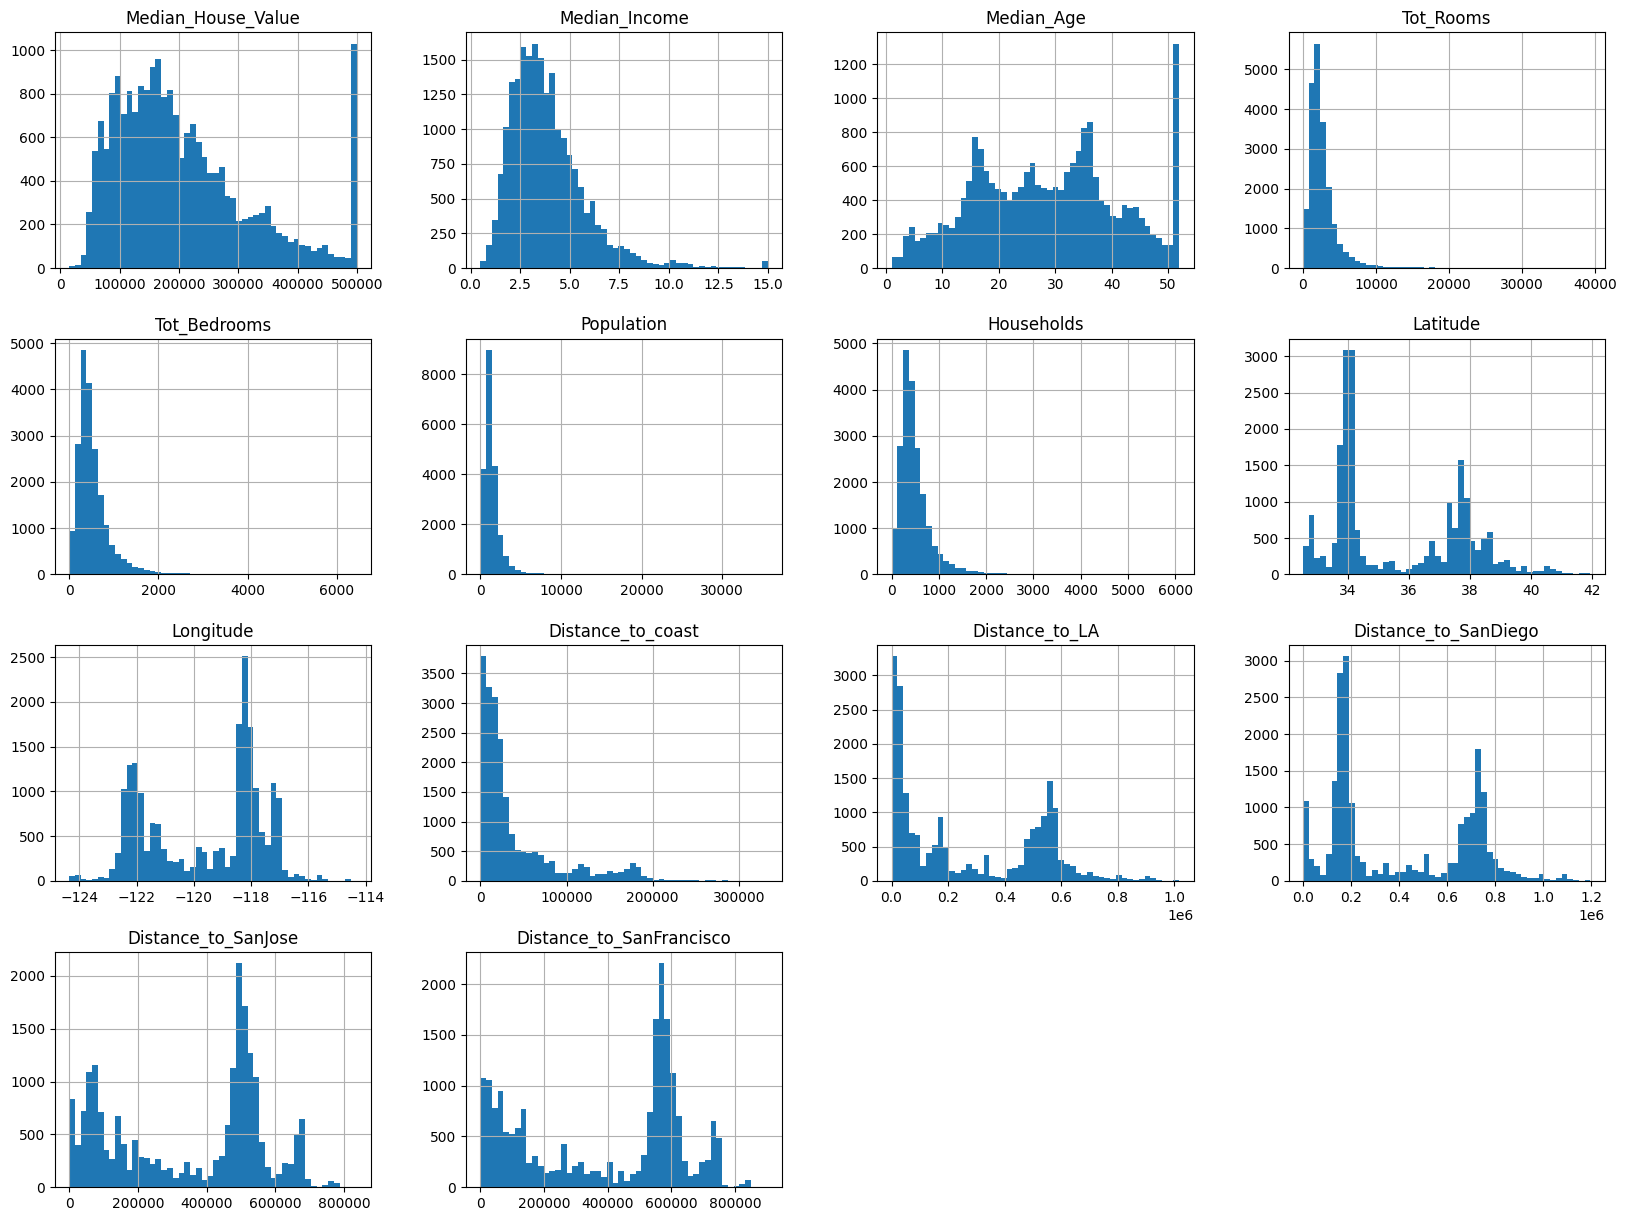

In [46]:
california_houses.hist(bins=50, figsize=(20,15))
plt.show()

## Splitting the data

In [47]:
#separate the prices (output we want to predict) from the features (x)
#drop the column (axis=1) from features X
x=california_houses.drop('Median_House_Value', axis=1)
#store them in y (output)
y=california_houses['Median_House_Value']

#split the data to 70% training, 30%
X_train, X_t, y_train, y_t = train_test_split(x, y, test_size=0.3, random_state=42)
#then to 15% val, 15% testing,random_state= any number, to use the same random testing every time
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=0.5, random_state=42)


In [48]:
#checking the split ratios
total_len = len(california_houses)
train_ratio = len(X_train) / total_len
val_ratio = len(X_val) / total_len
test_ratio = len(X_test) / total_len

print(f"Train: {train_ratio:.2%}, Val: {val_ratio:.2%}, Test: {test_ratio:.2%}")

Train: 70.00%, Val: 15.00%, Test: 15.00%


## Preparing the data

- Scaling (x) features to ensure all features are on a similar scale

- adding ones column to X for the bias intercept

In [49]:
#feature scaling (standardization) (( x - mean ) / std deviation) 
#std -> how the data is spread around the mean (centre of data)
scaler = StandardScaler()
# .fit_transform fits the scaler to the training data and transforms it
X_train_scaled = scaler.fit_transform(X_train)
#.transform transforms the validation and testing data using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#creates an array of ones with the same number of rows as X_train
#.c_ concatenates the ones column to X_train to the left side
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_val_b = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

## Linear Regression Manually

- Implementing linear regression from scratch using matrix operations

In [50]:
#normal equation method
#theta_best = (X^T * X)^-1 * X^T * y
#linalg-> linear algebra
theta_best = np.linalg.inv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train)

#predictions
# @ is matrix multiplication(dot product)
y_train_pred_linear_normal = X_train_b @ theta_best
y_val_pred_linear_normal = X_val_b @ theta_best
y_test_pred_linear_normal = X_test_b @ theta_best

Evaluating the Mnaual linear regression model 

- Using MSE & MAE

In [51]:
#mean squared error
mse_train_linear = mean_squared_error(y_train, y_train_pred_linear_normal)
mse_val_linear = mean_squared_error(y_val, y_val_pred_linear_normal)
mse_test_linear = mean_squared_error(y_test, y_test_pred_linear_normal)

#mean absolute error
mae_train_linear = mean_absolute_error(y_train, y_train_pred_linear_normal)
mae_val_linear = mean_absolute_error(y_val, y_val_pred_linear_normal)
mae_test_linear = mean_absolute_error(y_test, y_test_pred_linear_normal)

print(f"Linear Regression normal MSE: Train: {mse_train_linear:.2f}, Val: {mse_val_linear:.2f}, Test: {mse_test_linear:.2f}")
print(f"Linear Regression normal MAE: Train: {mae_train_linear:.2f}, Val: {mae_val_linear:.2f}, Test: {mae_test_linear:.2f}")

Linear Regression normal MSE: Train: 4730358742.50, Val: 4907211997.37, Test: 4400953150.61
Linear Regression normal MAE: Train: 49927.00, Val: 50790.06, Test: 48782.03


## linear regression using gradient descent 
- **n_iterations** = number of steps 
- **learning_rate** = step size
- **MSE** = (1/n) * sum((y - y_pred)^2) -> derivative of MSE wrt w = (2/n) * X^T * (y_pred - y)
- **step_size**= learning_rate*slope(gradient)
- **w_new** = w_old - step_size

In [52]:
def gradient_descent(X, y, learning_rate=0.001, n_iterations=1000):
    #initialize weights (w) to zeros (the slopes of the features)
    #weight vector of size equal to number of features
    w = np.zeros(X.shape[1])
    #n= n_samples (number of rows in X)
    n = len(X)
    costs = []

    for iteration in range(n_iterations):
        # predictions
        y_pred = X @ w

        gradients = (2/n) * X.T @ (y_pred - y)

        #update weights
        w = w - learning_rate * gradients

        #calculating cost
        cost = mean_squared_error(y, y_pred)
        costs.append(cost)

        # checking if cost is too large
        if np.isnan(cost) or np.isinf(cost):
            break

    return w, costs


Tuning the learning rate hyperparameter
- looping over different learning rates and returning the one with the least cost 

In [53]:
def tune_learning_rate(X, y, learning_rates, n_iterations=1000):
    best_lr = None
    best_w = None
    best_cost = float("inf")
    lr_costs = {} # to store costs for each learning rate

    for learning_rate in learning_rates:
        w, costs = gradient_descent(X, y, learning_rate=learning_rate, n_iterations=n_iterations)

        #final cost is the last cost in the list else float("inf")
        final_cost = costs[-1] if len(costs) > 0 else float("inf")
        #storing the final cost for the current learning rate
        lr_costs[learning_rate] = final_cost

        if final_cost < best_cost:
            best_cost = final_cost
            best_lr = learning_rate
            best_w = w

    print("Learning rate tuning completed")
    print(f"Best learning rate: {best_lr}")
    print(f"Final cost: {best_cost}")

    return best_w, best_lr, lr_costs


#looping through different learning rates to find the best one
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
theta_gd, best_lr, lr_costs = tune_learning_rate(X_train_b, y_train, learning_rates=learning_rates, n_iterations=7000)  

Learning rate tuning completed
Best learning rate: 0.1
Final cost: 4730408167.975366


Predictions of Linear regression using gradient descent

In [54]:
#predictions
y_train_pred_linear_gd = X_train_b @ theta_gd
y_val_pred_linear_gd = X_val_b @ theta_gd
y_test_pred_linear_gd = X_test_b @ theta_gd

Evaluating the gradient descent linear regression model 
- Using MSE and MAE

In [55]:
#mean squared error penalized for large errors more
linear_gd_mse_train = mean_squared_error(y_train, y_train_pred_linear_gd)
linear_gd_mse_val = mean_squared_error(y_val, y_val_pred_linear_gd)
linear_gd_mse_test = mean_squared_error(y_test, y_test_pred_linear_gd)
print(f"Linear Regression GD MSE: Train: {linear_gd_mse_train:.2f}, Val: {linear_gd_mse_val:.2f}, Test: {linear_gd_mse_test:.2f}")

#mean absolute error penalized for all errors equally
linear_gd_mae_train = mean_absolute_error(y_train, y_train_pred_linear_gd)
linear_gd_mae_val = mean_absolute_error(y_val, y_val_pred_linear_gd)
linear_gd_mae_test = mean_absolute_error(y_test, y_test_pred_linear_gd)

print(f"Linear Regression GD MAE: Train: {linear_gd_mae_train:.2f}, Val: {linear_gd_mae_val:.2f}, Test: {linear_gd_mae_test:.2f}")

Linear Regression GD MSE: Train: 4730408123.01, Val: 4907251335.58, Test: 4400381466.22
Linear Regression GD MAE: Train: 49930.54, Val: 50793.08, Test: 48784.01


Plotting learning rates against MSE to visualize convergence

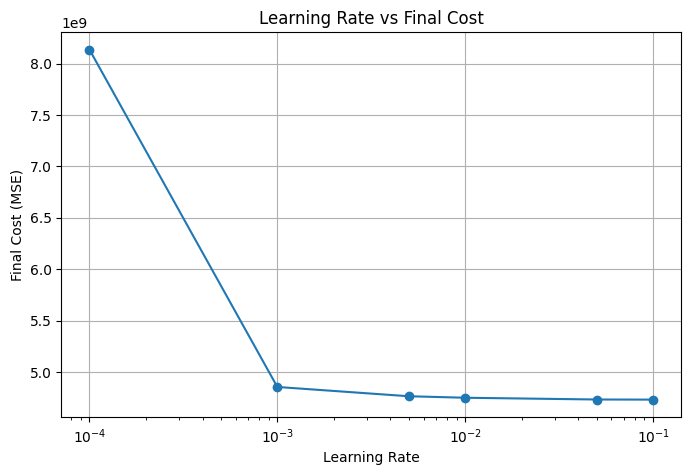

In [56]:
#Convert dictionary to lists for plotting
learning_rates = list(lr_costs.keys())
costs = list(lr_costs.values())

plt.figure(figsize=(8,5))
plt.plot(learning_rates, costs, marker='o')
plt.xscale('log')  # Use log scale for learning rates
plt.xlabel('Learning Rate')
plt.ylabel('Final Cost (MSE)')
plt.title('Learning Rate vs Final Cost')
plt.grid(True)
plt.show()

## linear regression using sicklit

In [57]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

y_train_pred_linear_sklearn = linear_model.predict(X_train_scaled)
y_val_pred_linear_sklearn = linear_model.predict(X_val_scaled)
y_test_pred_linear_sklearn = linear_model.predict(X_test_scaled)

Evaluating the sicklitlearn linear regression model 
- Using MSE and MAE

In [58]:
mse_train_sklearn = mean_squared_error(y_train, y_train_pred_linear_sklearn)
mse_val_sklearn = mean_squared_error(y_val, y_val_pred_linear_sklearn)
mse_test_sklearn = mean_squared_error(y_test, y_test_pred_linear_sklearn)

mae_train_sklearn = mean_absolute_error(y_train, y_train_pred_linear_sklearn)
mae_val_sklearn = mean_absolute_error(y_val, y_val_pred_linear_sklearn)
mae_test_sklearn = mean_absolute_error(y_test, y_test_pred_linear_sklearn)

print(f"Sklearn Linear Regression MSE: Train: {mse_train_sklearn:.2f}, Val: {mse_val_sklearn:.2f}, Test: {mse_test_sklearn:.2f}")
print(f"Sklearn Linear Regression MAE: Train: {mae_train_sklearn:.2f}, Val: {mae_val_sklearn:.2f}, Test: {mae_test_sklearn:.2f}")

Sklearn Linear Regression MSE: Train: 4730358742.50, Val: 4907211997.37, Test: 4400953150.61
Sklearn Linear Regression MAE: Train: 49927.00, Val: 50790.06, Test: 48782.03


## Ridge Regression
- main idea of ridge regression is finding a line that doesnt fit the training data as well (avoiding overfitting)
achieving low variance -> model doesnt change a lot if training data changes
it adds penality (lambda*slope^2) to the sum of squared residual -> sum(squared residual)+(lambda * slop^2)
ridge regression results in line that has a smaller slope therefore it is less sensitive to changes in x (training data)
as lambda increases, the slope decreases and becomes more flat, and model becomes less sensitive

Ridge regression manually

In [59]:
#w=(X^T * X + lambda*I)^-1 * X^T * y
#I is identity matrix

def ridge_regression_normal(X, y, lambda_):
    #np.eye creates an identity matrix of size (n_features, n_features)
    #1 in diagonal, 0 elsewhere
    #x.shape[1] -> number of features (columns)
    I = np.eye(X.shape[1])
    #do not regularize the bias term (intercept)
    I[0, 0] = 0
    #.solve more stable than .inv, solveses the linear system but avoids explicitly computing the inverse
    w_ridge = np.linalg.solve(X.T @ X + lambda_ * I, X.T @ y)
    return w_ridge

Tunning the hyperparameter -> lambda

In [60]:
#lambda values
#wider range of lambda values to test for better regularization, smaller range had a constant MSE
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

#ridge mean squared error for different lambda values
ridge_regression_mse=[]

for l in lambdas:
    w_ridge = ridge_regression_normal(X_train_b, y_train, l)
    y_val_pred_ridge = X_val_b @ w_ridge
    mse_val_ridge = mean_squared_error(y_val, y_val_pred_ridge)
    ridge_regression_mse.append(mse_val_ridge)


convergence visualization 

- plotting lambdas against MSE

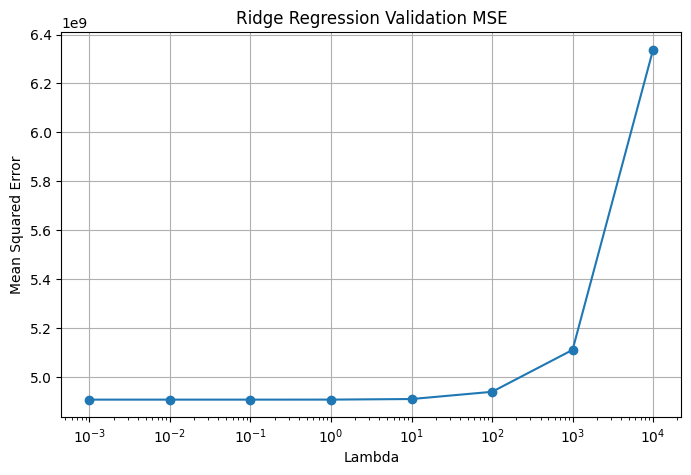

In [61]:
plt.figure(figsize=(8,5))
plt.plot(lambdas, ridge_regression_mse, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression Validation MSE')
plt.grid()
plt.show()

finding best lambda

In [62]:
#np.argmin returns the index of the minimum value in the array
best_lambda = lambdas[np.argmin(ridge_regression_mse)]
w_ridge_best = ridge_regression_normal(X_train_b, y_train, best_lambda)
y_test_pred_ridge_normal = X_test_b @ w_ridge_best
y_val_pred_ridge_normal = X_val_b @ w_ridge_best
y_train_pred_ridge_normal = X_train_b @ w_ridge_best
print("Best lambda: ", best_lambda)

Best lambda:  0.001


Evaluating the ridge regression manual solution

- using mse and mae

In [63]:
mse_train_ridge_normal = mean_squared_error(y_train, y_train_pred_ridge_normal)
mse_val_ridge_normal = mean_squared_error(y_val, y_val_pred_ridge_normal)
mse_test_ridge_normal = mean_squared_error(y_test, y_test_pred_ridge_normal)
mae_train_ridge_normal = mean_absolute_error(y_train, y_train_pred_ridge_normal)
mae_val_ridge_normal = mean_absolute_error(y_val, y_val_pred_ridge_normal)
mae_test_ridge_normal = mean_absolute_error(y_test, y_test_pred_ridge_normal)

print(f"Ridge Regression Normal Test MSE: {mse_test_ridge_normal:.2f}, Validation MSE: {mse_val_ridge_normal:.2f}, Training MSE: {mse_train_ridge_normal:.2f}")
print(f"Ridge Regression Normal Test MAE: {mae_test_ridge_normal:.2f}, Validation MAE: {mae_val_ridge_normal:.2f}, Training MAE: {mae_train_ridge_normal:.2f}")

Ridge Regression Normal Test MSE: 4400952696.86, Validation MSE: 4907212034.98, Training MSE: 4730358742.53
Ridge Regression Normal Test MAE: 48782.03, Validation MAE: 50790.06, Training MAE: 49927.01


## Ridge using gradient descent 

In [64]:
def ridge_gradient_descent(X, y, alpha=0.01, learning_rate=0.001, n_iterations=1500):
    # Initialize weights (w) to zeros
    w = np.zeros(X.shape[1])
    n = len(X)

    costs = []

    for iteration in range(n_iterations):
        # Predictions
        y_pred = X @ w

        # no regularization for the bias term (index 0)
        gradient = (-2 / n) * X.T @ (y - y_pred)
        
        # Adding L2 penalty only to non-bias weights
        l2_penalty = np.zeros_like(w)
        l2_penalty[1:] = 2 * alpha * w[1:]
        gradient += l2_penalty

        # Update weights
        w = w - learning_rate * gradient

        # Cost function MSE + regularization term
        mse = np.mean((y - y_pred) ** 2)
        cost = mse + alpha * np.sum(w[1:] ** 2)
        costs.append(cost)

        # Break if cost diverges
        if np.isnan(cost) or np.isinf(cost):
            break

    return w, costs


Tunning the learning rate hyperparameter for ridge

In [65]:
def tune_learning_rate_ridge(X, y, alpha, learning_rates=learning_rates, n_iterations=1500):
    best_lr = None
    best_w = None
    best_cost = float("inf")

    for lr in learning_rates:
        w, costs = ridge_gradient_descent(X, y, alpha=alpha, learning_rate=lr, n_iterations=n_iterations)
        final_cost = costs[-1] if len(costs) > 0 else float("inf")

        if final_cost < best_cost:
            best_cost = final_cost
            best_lr = lr
            best_w = w
    return best_w, best_lr, best_cost

Tunning the alpha hyperparameter for ridge

In [66]:
def tune_alpha_ridge(X, y, alphas, learning_rates=learning_rates, n_iterations=1500):
    best_alpha = None
    best_lr = None
    best_w = None
    best_cost = float("inf")

    for alpha in alphas:
        #print(f"Testing alpha={alpha}")
        w, lr, cost = tune_learning_rate_ridge(X, y, alpha, learning_rates, n_iterations)

        if cost < best_cost:
            best_alpha = alpha
            best_lr = lr
            best_cost = cost
            best_w = w

    print("Ridge tuning completed")
    print(f"Best alpha: {best_alpha}")
    print(f"Best learning rate: {best_lr}")
    print(f"Final cost: {best_cost:.2f}")

    return best_w, best_alpha, best_lr

Tuning both alpha and learning rate

In [67]:
alphas = [1e-2, 1e-3,1e-4]  
learning_rates = [0.001, 0.01, 0.1]

best_w_ridge, best_alpha, best_lr= tune_alpha_ridge(
    X_train_b, y_train,
    alphas=alphas,
    learning_rates=learning_rates,
    n_iterations=7000
)


Ridge tuning completed
Best alpha: 0.0001
Best learning rate: 0.1
Final cost: 4733472273.07


Predictions

In [68]:
y_train_pred_ridge_gd = X_train_b @ best_w_ridge
y_val_pred_ridge_gd = X_val_b @ best_w_ridge
y_test_pred_ridge_gd = X_test_b @ best_w_ridge

Evaluating the ridge gradient descent model 
- Using MSE and MAE

In [69]:
mse_train_ridge_gd = mean_squared_error(y_train, y_train_pred_ridge_gd)
mse_val_ridge_gd = mean_squared_error(y_val, y_val_pred_ridge_gd)
mse_test_ridge_gd = mean_squared_error(y_test, y_test_pred_ridge_gd)

mae_train_ridge_gd = mean_absolute_error(y_train, y_train_pred_ridge_gd)
mae_val_ridge_gd = mean_absolute_error(y_val, y_val_pred_ridge_gd)
mae_test_ridge_gd = mean_absolute_error(y_test, y_test_pred_ridge_gd)

print(f"Ridge Regression Gradient Descent Test MSE: {mse_test_ridge_gd:.2f}, Validation MSE: {mse_val_ridge_gd:.2f}, Training MSE: {mse_train_ridge_gd:.2f}")
print(f"Ridge Regression Gradient Descent Test MAE: {mae_test_ridge_gd:.2f}, Validation MAE: {mae_val_ridge_gd:.2f}, Training MAE: {mae_train_ridge_gd:.2f}")


Ridge Regression Gradient Descent Test MSE: 4399970799.27, Validation MSE: 4907451682.70, Training MSE: 4730536293.94
Ridge Regression Gradient Descent Test MAE: 48787.70, Validation MAE: 50797.84, Training MAE: 49935.62


Plotting lambdas & learing rates against MSE

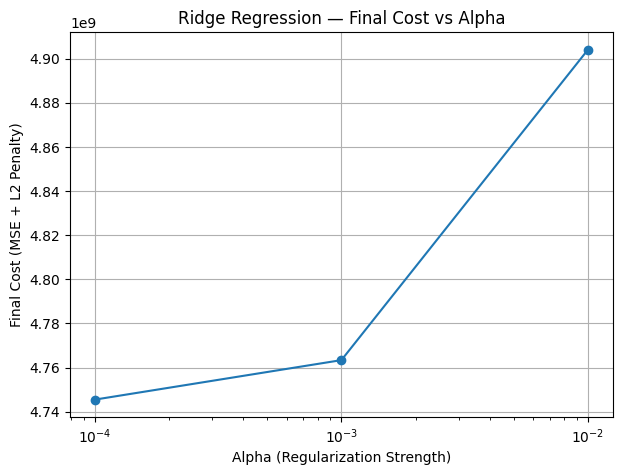

In [70]:
alpha_costs = []

for alpha in alphas:
    _, _, cost = tune_learning_rate_ridge(X_train_b, y_train, alpha, learning_rates, n_iterations=1000)
    alpha_costs.append(cost)

plt.figure(figsize=(7,5))
plt.semilogx(alphas, alpha_costs, marker='o')
plt.title("Ridge Regression — Final Cost vs Alpha")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Final Cost (MSE + L2 Penalty)")
plt.grid(True)
plt.show()


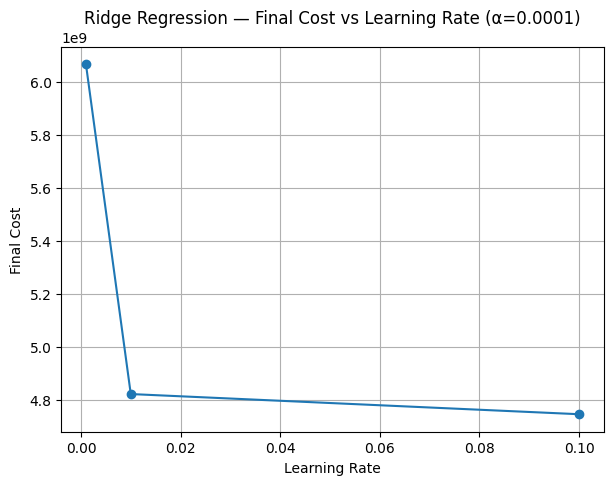

In [71]:
lr_costs = []

for lr in learning_rates:
    w, costs = ridge_gradient_descent(X_train_b, y_train, alpha=best_alpha, learning_rate=lr, n_iterations=1000)
    lr_costs.append(costs[-1])

plt.figure(figsize=(7,5))
plt.plot(learning_rates, lr_costs, marker='o')
plt.title(f"Ridge Regression — Final Cost vs Learning Rate (α={best_alpha})")
plt.xlabel("Learning Rate")
plt.ylabel("Final Cost")
plt.grid(True)
plt.show()

## Ridge regression using sicklit 

In [72]:
#ridge regression using sklearn for different lambda values
# Compact range showing full regularization spectrum
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ridge_sklearn_mse = []

for l in lambdas:
    model = Ridge(alpha=l)
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    ridge_sklearn_mse.append(mean_squared_error(y_val, y_val_pred))

Convergence visualization of Ridge sicklit

- plotting lambdas against MSE

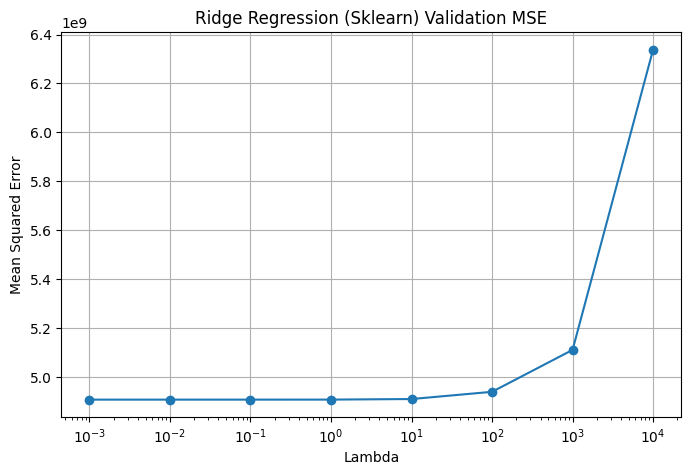

In [73]:
plt.figure(figsize=(8,5))
plt.plot(lambdas, ridge_sklearn_mse, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression (Sklearn) Validation MSE')
plt.grid()
plt.show()

Finding the best lambda

In [74]:
best_lambda_sklearn = lambdas[np.argmin(ridge_sklearn_mse)]
#finding the best model and training it on the whole training set
ridge_model=Ridge(alpha=best_lambda_sklearn)
ridge_model.fit(X_train_scaled, y_train);

Predictions for ridge using sicklit 

In [75]:
y_test_pred_ridge_sklearn = ridge_model.predict(X_test_scaled)
y_val_pred_ridge_sklearn = ridge_model.predict(X_val_scaled)
y_train_pred_ridge_sklearn = ridge_model.predict(X_train_scaled)

Evaluating the ridge sicklit model 
- Using MSE and MAE

In [76]:
mse_ridge_train_sklearn = mean_squared_error(y_train, y_train_pred_ridge_sklearn)
mse_ridge_val_sklearn = mean_squared_error(y_val, y_val_pred_ridge_sklearn)
mse_ridge_test_sklearn = mean_squared_error(y_test, y_test_pred_ridge_sklearn)
mae_ridge_train_sklearn = mean_absolute_error(y_train, y_train_pred_ridge_sklearn)
mae_ridge_val_sklearn = mean_absolute_error(y_val, y_val_pred_ridge_sklearn)
mae_ridge_test_sklearn = mean_absolute_error(y_test, y_test_pred_ridge_sklearn)
print("Best lambda (Sklearn): ", best_lambda_sklearn)
print(f"Ridge Regression (Sklearn) Test MSE: {mse_ridge_test_sklearn:.2f}, Validation MSE: {mse_ridge_val_sklearn:.2f}, Training MSE: {mse_ridge_train_sklearn:.2f}")
print(f"Ridge Regression (Sklearn) Test MAE: {mae_ridge_test_sklearn:.2f}, Validation MAE: {mae_ridge_val_sklearn:.2f}, Training MAE: {mae_ridge_train_sklearn:.2f}")

Best lambda (Sklearn):  0.001
Ridge Regression (Sklearn) Test MSE: 4400952696.86, Validation MSE: 4907212034.98, Training MSE: 4730358742.53
Ridge Regression (Sklearn) Test MAE: 48782.03, Validation MAE: 50790.06, Training MAE: 49927.01


Lasso Regression Manually


- Adds an L1 regularization term to the cost function:
Cost = MSE (Mean Sum of Errors) + λ ∑ |wi|
- Used when you suspect only some features are important.
- Can completely eliminate some features → performs feature selection (Can make some weights exactly zero).

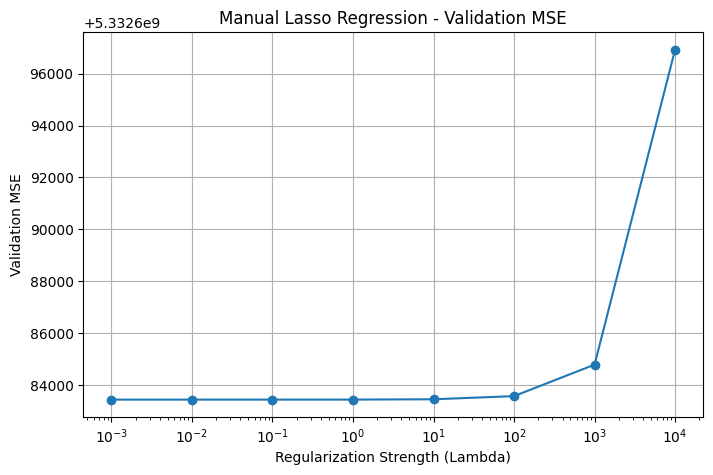

Manual Lasso Regression Results:
  Best Lambda: 0.001
  Lasso Regression Normal Test MSE: 4817466183.58, Validation MSE: 5332683448.11, Training MSE: 5110333927.07
  Lasso Regression Normal Test MAE 51650.02, Validation MAE: 53522.56, Training MAE: 52684.59


In [ ]:
# Using Coordinate Descent
# this function “shrinks” small values toward zero.
def soft_threshold(value, threshold):
    if value > threshold:
        return value - threshold # If value is greater than the threshold → reduce it slightly.
    elif value < -threshold:
        return value + threshold # If it’s smaller → increase it slightly.
    else:
        return 0

def lasso_manual(X, y, lambda_val, max_iterations=2, tolerance=1e-3):

    m, n = X.shape
    weights = np.zeros(n)
    
    for iteration in range(max_iterations):
        old_weights = weights.copy()
        for j in range(n):
            #Compute residual excluding feature j
            # rj = y - Xw + wj Xj
            residual = y - X @ weights + weights[j] * X[:, j]
            rho = X[:, j].T @ residual #Measure correlation between feature j and residual
            denom = np.sum(X[:, j] ** 2)
            if denom != 0:
                # wj​= S ( rho ​/ ∥Xj​∥ ^ 2 , λ / (2 ∥Xj​∥ ^ 2))
                weights[j] = soft_threshold(rho / denom, lambda_val / (2 * denom))

        # Check convergence, if weights barely change, the algorithm stops early.
        if np.linalg.norm(weights - old_weights, ord=1) < tolerance:
            break
    return weights


# List of regularization strengths to test (λ values)
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

validation_mse_list = []

# Loop through each lambda and compute validation MSE
for lambda_value in lambdas:
    weights_lasso = lasso_manual(X_train_b, y_train, lambda_value)
    y_validation_pred = X_val_b @ weights_lasso
    mse_validation = mean_squared_error(y_val, y_validation_pred)
    validation_mse_list.append(mse_validation)

# Plot Validation MSE vs. Lambda
plt.figure(figsize=(8,5))
plt.plot(lambdas, validation_mse_list, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (Lambda)')
plt.ylabel('Validation MSE')
plt.title('Manual Lasso Regression - Validation MSE')
plt.grid(True)
plt.show()

# Select best lambda (minimum validation MSE)
best_lambda = lambdas[np.argmin(validation_mse_list)]

# Train final model using best lambda
best_weights = lasso_manual(X_train_b, y_train, best_lambda)

# Predictions
y_test_pred = X_test_b @ best_weights
y_val_pred = X_val_b @ best_weights
y_train_pred = X_train_b @ best_weights


mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

#Print results
print(f"Manual Lasso Regression Results:")
print(f"  Best Lambda: {best_lambda}")
print(f"  Lasso Regression Normal Test MSE: {mse_test:.2f}, Validation MSE: {mse_val:.2f}, Training MSE: {mse_train:.2f}")
print(f"  Lasso Regression Normal Test MAE {mae_test:.2f}, Validation MAE: {mae_val:.2f}, Training MAE: {mae_train:.2f}")


## Lasso Regression using Scikit

In [78]:
# Lasso regression using sklearn for different lambda values
# Compact range showing full regularization spectrum

lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lasso_sklearn_mse = []

for l in lambdas:
    model = Lasso(alpha=l)
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    lasso_sklearn_mse.append(mean_squared_error(y_val, y_val_pred))

Convergence visualization of Lasso sicklit

- plotting lambdas against MSE

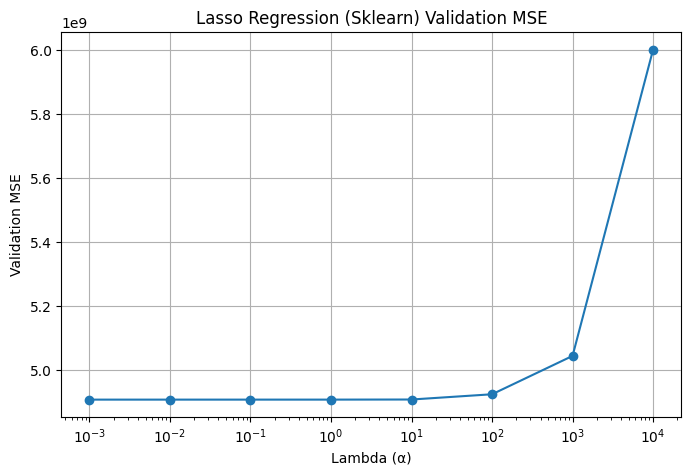

In [79]:
plt.figure(figsize=(8,5))
plt.plot(lambdas, lasso_sklearn_mse, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (α)')
plt.ylabel('Validation MSE')
plt.title('Lasso Regression (Sklearn) Validation MSE')
plt.grid()
plt.show()

Finding the best lambda

In [80]:
best_lambda_sklearn = lambdas[np.argmin(lasso_sklearn_mse)]
#finding the best model and training it on the whole training set
lasso_model = Lasso(alpha=best_lambda_sklearn)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.001)

Predictions for lasso using scikit

In [81]:
y_train_pred_lasso_sklearn = lasso_model.predict(X_train_scaled)
y_val_pred_lasso_sklearn = lasso_model.predict(X_val_scaled)
y_test_pred_lasso_sklearn = lasso_model.predict(X_test_scaled)

Evaluating the lasso scikit model

- Using MSE and MAE

In [82]:
mse_lasso_train_sklearn = mean_squared_error(y_train, y_train_pred_lasso_sklearn)
mse_lasso_val_sklearn = mean_squared_error(y_val, y_val_pred_lasso_sklearn)
mse_lasso_test_sklearn = mean_squared_error(y_test, y_test_pred_lasso_sklearn)
mae_lasso_train_sklearn = mean_absolute_error(y_train, y_train_pred_lasso_sklearn)
mae_lasso_val_sklearn = mean_absolute_error(y_val, y_val_pred_lasso_sklearn)
mae_lasso_test_sklearn = mean_absolute_error(y_test, y_test_pred_lasso_sklearn)
print("Best lambda (Sklearn): ", best_lambda_sklearn)
print(f"Lasso Regression (Sklearn) Test MSE: {mse_lasso_test_sklearn:.2f}, Validation MSE: {mse_lasso_val_sklearn:.2f}, Training MSE: {mse_lasso_train_sklearn:.2f}")
print(f"Lasso Regression (Sklearn) Test MAE: {mae_lasso_test_sklearn:.2f}, Validation MAE: {mae_lasso_val_sklearn:.2f}, Training MAE: {mae_lasso_train_sklearn:.2f}")

Best lambda (Sklearn):  0.001
Lasso Regression (Sklearn) Test MSE: 4400731898.96, Validation MSE: 4907208018.68, Training MSE: 4730361131.00
Lasso Regression (Sklearn) Test MAE: 48781.67, Validation MAE: 50790.11, Training MAE: 49927.07


## Comparing MSE & MAE for GD & Normal Eq Linear

In [83]:
comparison_linear_manual = pd.DataFrame({
    'Train MSE': [linear_gd_mse_train, mse_train_linear],
    'Val MSE': [linear_gd_mse_val, mse_val_linear],
    'Test MSE': [linear_gd_mse_test, mse_test_linear],
    'Train MAE': [linear_gd_mae_train, mae_train_linear],
    'Val MAE': [linear_gd_mae_val, mae_val_linear],
    'Test MAE': [linear_gd_mae_test, mae_test_linear]
}, index=['Gradient Descent', 'Normal Equation'])

print("Linear Regression (Manual Implementation)")
display(comparison_linear_manual.round(4))


Linear Regression (Manual Implementation)


Train MSE       Val MSE      Test MSE   Train MAE  \
Gradient Descent  4.730408e+09  4.907251e+09  4.400381e+09  49930.5362   
Normal Equation   4.730359e+09  4.907212e+09  4.400953e+09  49927.0038   

                     Val MAE    Test MAE  
Gradient Descent  50793.0818  48784.0131  
Normal Equation   50790.0603  48782.0311

- Both implementations gave almost identical results 
- GD converged correctly to the optimal solution

## Comparing MSE & MAE for GD & Normal Eq Ridge

In [84]:
comparison_ridge_manual = pd.DataFrame({
    'Train MSE': [mse_train_ridge_gd, mse_train_ridge_normal],
    'Val MSE': [mse_val_ridge_gd, mse_val_ridge_normal],
    'Test MSE': [mse_test_ridge_gd, mse_test_ridge_normal],
    'Train MAE': [mae_train_ridge_gd, mae_train_ridge_normal],
    'Val MAE': [mae_val_ridge_gd, mae_val_ridge_normal],
    'Test MAE': [mae_test_ridge_gd, mae_test_ridge_normal]
}, index=['Gradient Descent', 'Normal Equation'])

print("Ridge Regression (GD & Normal Equation Comparison)")
display(comparison_ridge_manual.round(4))


Ridge Regression (GD & Normal Equation Comparison)


Train MSE       Val MSE      Test MSE   Train MAE  \
Gradient Descent  4.730536e+09  4.907452e+09  4.399971e+09  49935.6197   
Normal Equation   4.730359e+09  4.907212e+09  4.400953e+09  49927.0073   

                     Val MAE    Test MAE  
Gradient Descent  50797.8446  48787.7017  
Normal Equation   50790.0639  48782.0333

- Both implementations gave almost identical results 
- GD converged correctly to the optimal solution

## Comparison between linear, ridge in terms of GD & Normal Eq implementation 

Comparison: Linear vs Ridge (Normal Equation)


Train MSE       Val MSE      Test MSE   Train MAE  \
Linear (Normal Eq)  4.730359e+09  4.907212e+09  4.400953e+09  49927.0038   
Ridge (Normal Eq)   4.730359e+09  4.907212e+09  4.400953e+09  49927.0073   

                       Val MAE    Test MAE  
Linear (Normal Eq)  50790.0603  48782.0311  
Ridge (Normal Eq)   50790.0639  48782.0333

Comparison: Linear vs Ridge (Gradient Descent)


Train MSE       Val MSE      Test MSE   Train MAE     Val MAE  \
Linear (GD)  4.730408e+09  4.907251e+09  4.400381e+09  49930.5362  50793.0818   
Ridge (GD)   4.730536e+09  4.907452e+09  4.399971e+09  49935.6197  50797.8446   

               Test MAE  
Linear (GD)  48784.0131  
Ridge (GD)   48787.7017

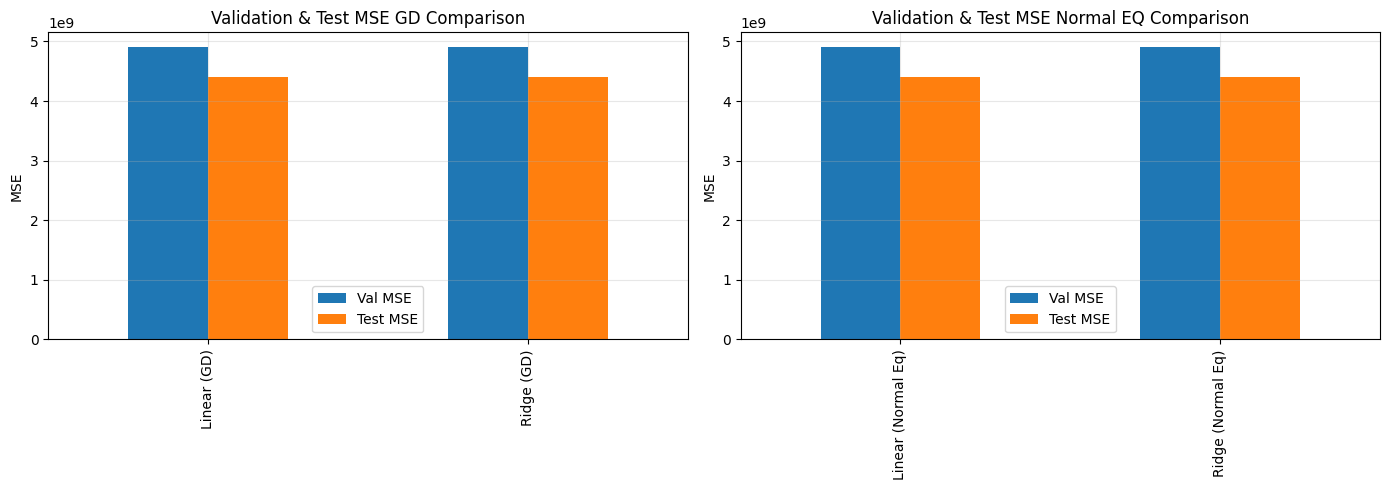

In [85]:
comparison_normal_eq = pd.DataFrame({
    'Train MSE': [mse_train_linear, mse_train_ridge_normal],
    'Val MSE': [mse_val_linear, mse_val_ridge_normal],
    'Test MSE': [mse_test_linear, mse_test_ridge_normal],
    'Train MAE': [mae_train_linear, mae_train_ridge_normal],
    'Val MAE': [mae_val_linear, mae_val_ridge_normal],
    'Test MAE': [mae_test_linear, mae_test_ridge_normal]
}, index=['Linear (Normal Eq)', 'Ridge (Normal Eq)'])

print("Comparison: Linear vs Ridge (Normal Equation)")
display(comparison_normal_eq.round(4))

comparison_gd = pd.DataFrame({
    'Train MSE': [linear_gd_mse_train, mse_train_ridge_gd],
    'Val MSE': [linear_gd_mse_val, mse_val_ridge_gd],
    'Test MSE': [linear_gd_mse_test, mse_test_ridge_gd],
    'Train MAE': [linear_gd_mae_train, mae_train_ridge_gd],
    'Val MAE': [linear_gd_mae_val, mae_val_ridge_gd],
    'Test MAE': [linear_gd_mae_test, mae_test_ridge_gd]
}, index=['Linear (GD)', 'Ridge (GD)'])

print("Comparison: Linear vs Ridge (Gradient Descent)")
display(comparison_gd.round(4))

fig,axes=plt.subplots(1,2, figsize=(14,5))
comparison_gd[['Val MSE', 'Test MSE']].plot(kind='bar', ax=axes[0], title='Validation & Test MSE GD Comparison')
axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3)
    
comparison_normal_eq[['Val MSE', 'Test MSE']].plot(kind='bar', ax=axes[1], title='Validation & Test MSE Normal EQ Comparison')
axes[1].set_ylabel('MSE')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Manual implementation for linear, ridge are giving nearly the same results 
- indicating that the regularization term is too small so ridge behaves almost like linear
- in Gd implementation, Ridge is slightly better in test MSE than linear which means regularization helped a little (prevented overfitting)

# Comparison between linear, ridge and lasso using Sicklit learn model

Comparison: Linear vs Ridge vs Lasso (Sklearn)


Train MSE       Val MSE      Test MSE   Train MAE     Val MAE  \
Linear  4.730359e+09  4.907212e+09  4.400953e+09  49927.0038  50790.0603   
Ridge   4.730359e+09  4.907212e+09  4.400953e+09  49927.0073  50790.0639   
Lasso   4.730361e+09  4.907208e+09  4.400732e+09  49927.0700  50790.1115   

          Test MAE  
Linear  48782.0311  
Ridge   48782.0333  
Lasso   48781.6668

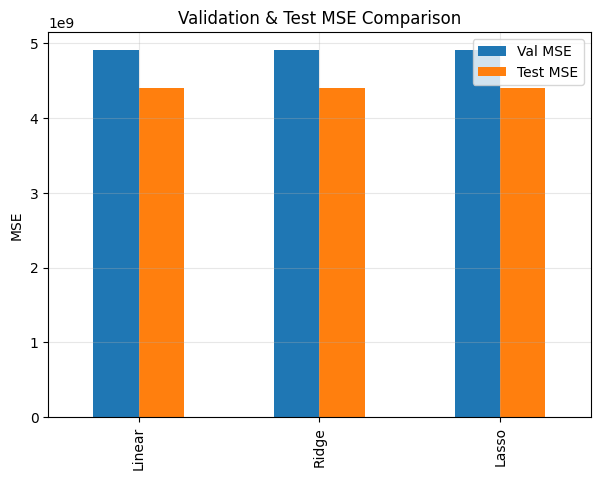

In [86]:
comparison_sklearn = pd.DataFrame({
    'Train MSE': [mse_train_sklearn, mse_ridge_train_sklearn, mse_lasso_train_sklearn],
    'Val MSE': [mse_val_sklearn, mse_ridge_val_sklearn, mse_lasso_val_sklearn],
    'Test MSE': [mse_test_sklearn, mse_ridge_test_sklearn, mse_lasso_test_sklearn],
    'Train MAE': [mae_train_sklearn, mae_ridge_train_sklearn, mae_lasso_train_sklearn],
    'Val MAE': [mae_val_sklearn, mae_ridge_val_sklearn, mae_lasso_val_sklearn],
    'Test MAE': [mae_test_sklearn, mae_ridge_test_sklearn, mae_lasso_test_sklearn]
}, index=['Linear', 'Ridge', 'Lasso'])

print("Comparison: Linear vs Ridge vs Lasso (Sklearn)")
display(comparison_sklearn.round(4))
 
comparison_sklearn[['Val MSE', 'Test MSE']].plot(kind='bar', figsize=(7,5), title='Validation & Test MSE Comparison')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)
plt.show()


## Comparing all models using accuracies (R2)

In [87]:
r2_train = r2_score(y_train, y_train_pred_linear_normal)
r2_val = r2_score(y_val, y_val_pred_linear_normal)
r2_test = r2_score(y_test, y_test_pred_linear_normal)

r2_train_ridge_normal = r2_score(y_train, y_train_pred_ridge_normal)
r2_val_ridge_normal = r2_score(y_val, y_val_pred_ridge_normal)
r2_test_ridge_normal = r2_score(y_test, y_test_pred_ridge_normal)

r2_train_gd = r2_score(y_train, y_train_pred_linear_gd)
r2_val_gd = r2_score(y_val, y_val_pred_linear_gd)
r2_test_gd = r2_score(y_test, y_test_pred_linear_gd)

r2_train_ridge_gd = r2_score(y_train, y_train_pred_ridge_gd)
r2_val_ridge_gd = r2_score(y_val, y_val_pred_ridge_gd)
r2_test_ridge_gd = r2_score(y_test, y_test_pred_ridge_gd)

r2_train_sklearn = r2_score(y_train, y_train_pred_linear_sklearn)
r2_val_sklearn = r2_score(y_val, y_val_pred_linear_sklearn)
r2_test_sklearn = r2_score(y_test, y_test_pred_linear_sklearn)


r2_train_ridge_sklearn = r2_score(y_train, y_train_pred_ridge_sklearn)
r2_val_ridge_sklearn = r2_score(y_val, y_val_pred_ridge_sklearn)
r2_test_ridge_sklearn = r2_score(y_test, y_test_pred_ridge_sklearn)

r2_train_lasso_sklearn = r2_score(y_train, y_train_pred_lasso_sklearn)
r2_val_lasso_sklearn = r2_score(y_val, y_val_pred_lasso_sklearn)
r2_test_lasso_sklearn = r2_score(y_test, y_test_pred_lasso_sklearn)

R² Score Comparison Across All Models


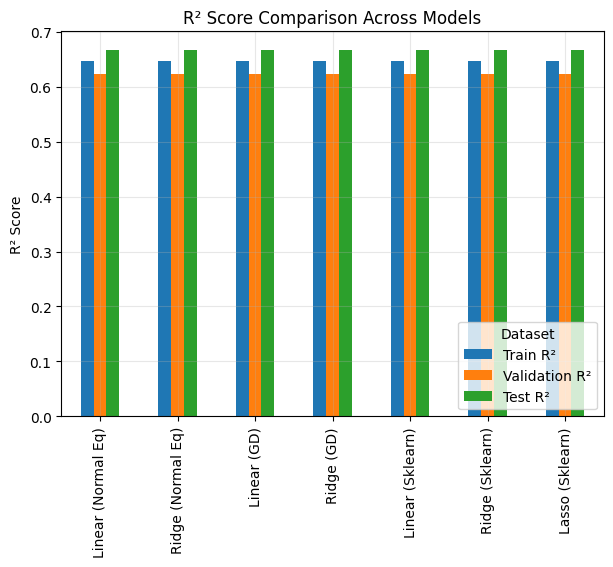

In [88]:
r2_scores = {
    'Linear (Normal Eq)': [r2_train, r2_val, r2_test],
    'Ridge (Normal Eq)': [r2_train_ridge_normal, r2_val_ridge_normal, r2_test_ridge_normal],
    'Linear (GD)': [r2_train_gd, r2_val_gd, r2_test_gd],
    'Ridge (GD)': [r2_train_ridge_gd, r2_val_ridge_gd, r2_test_ridge_gd],
    'Linear (Sklearn)': [r2_train_sklearn, r2_val_sklearn, r2_test_sklearn],
    'Ridge (Sklearn)': [r2_train_ridge_sklearn, r2_val_ridge_sklearn, r2_test_ridge_sklearn],
    'Lasso (Sklearn)': [r2_train_lasso_sklearn, r2_val_lasso_sklearn, r2_test_lasso_sklearn],

}

#transpose so rows = models, cols = datasets
r2_comparison = pd.DataFrame(r2_scores, index=['Train R²', 'Validation R²', 'Test R²']).T

print("R² Score Comparison Across All Models")
display(
    r2_comparison.round(4)
    .style.background_gradient(cmap='YlGnBu')
    .set_caption("Model Performance (R² Scores)")
)

r2_comparison.plot(kind='bar', figsize=(7,5))
plt.title("R² Score Comparison Across Models")
plt.ylabel("R² Score") 
plt.grid(True, alpha=0.3)
plt.legend(title="Dataset", loc='lower right')
plt.show()
